# Import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.despine()
sns.set_context('notebook') 
sns.set_style('ticks') 

colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)

# Import dataset

In [2]:
data = pd.read_csv('train.csv')
data = data.drop(columns='Id')
pd.set_option('display.max_columns', 100)
data.head()

,price,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,reviews_per_month
0,150,f,22.0,t,-33.846469,151.205171,Apartment,Entire home/apt,2,1.0,1,1.0,500.0,330.0,0,7,1125,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,strict,0.53
1,66,f,1.0,t,-33.895736,151.173529,Apartment,Private room,2,1.5,1,1.0,NaN,NaN,0,21,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,NaN
2,325,t,1.0,t,-33.879322,151.222408,House,Entire home/apt,4,2.0,2,2.0,500.0,180.0,0,3,90,21,99.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,moderate,2.38
3,145,f,1.0,f,-33.856874,151.149600,House,Entire home/apt,6,1.5,3,4.0,0.0,80.0,0,4,1125,3,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,flexible,1.96
4,200,f,6.0,t,-33.907150,151.178552,House,Entire home/apt,4,1.0,2,2.0,350.0,85.0,50,2,30,22,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,moderate,2.73


# Data Processing

In [3]:
# Missing data
missing_data = data.isnull().sum(axis=0).reset_index()
missing_data.columns = ['Predictor', 'Count of NaN values']
missing_data['Missing Ratio'] = missing_data['Count of NaN values'] / data.shape[0]
missing_data.loc[missing_data['Missing Ratio'] > 0]

,Predictor,Count of NaN values,Missing Ratio
1,host_is_superhost,2,0.002
2,host_total_listings_count,2,0.002
3,host_identity_verified,2,0.002
9,bathrooms,3,0.003
11,beds,2,0.002
12,security_deposit,426,0.426
13,cleaning_fee,307,0.307
18,review_scores_rating,340,0.340
19,review_scores_accuracy,342,0.342
20,review_scores_cleanliness,342,0.342


In [4]:
col = 'host_identity_verified'
pd.crosstab(data[col], data[col])

host_identity_verified,f,t
host_identity_verified,,
f,509,0
t,0,489


In [5]:
col = 'host_is_superhost'
pd.crosstab(data[col], data[col])

host_is_superhost,f,t
host_is_superhost,,
f,905,0
t,0,93


### Imputing missing data

In [6]:
# Categoricals
data['host_is_superhost'].fillna(value='f', inplace=True)
data['host_identity_verified'].fillna(value='f', inplace=True)

# No costs
data['security_deposit'].fillna(value=0, inplace=True)
data['cleaning_fee'].fillna(value=0, inplace=True)

# Medians
data['bathrooms'].fillna(value=np.nanmedian(data['bedrooms']), inplace=True)
data['beds'].fillna(value=np.nanmedian(data['beds']), inplace=True)
data['host_total_listings_count'].fillna(value=np.nanmedian(data['host_total_listings_count']), inplace=True)

#Reviews
review_data = data.filter(regex='review')

no_reviews = review_data.loc[review_data['number_of_reviews'] == 0]
reviews = review_data.loc[review_data['number_of_reviews'] > 0]

no_reviews = no_reviews.fillna(value=0)
review_data = pd.concat([reviews, no_reviews], ignore_index=False).sort_index()

# Need to still impute some review data that has number > 0, as it was still missing
from sklearn.preprocessing import Imputer
impute = Imputer(strategy='median')
review_data_clean = impute.fit_transform(review_data)
review_data_clean = pd.DataFrame(review_data_clean, columns=review_data.columns)

# Combining cleaned data
data = data.drop(columns=review_data.columns)
data = pd.concat([data, review_data_clean], axis=1)
data.head()

,price,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,150,f,22.0,t,-33.846469,151.205171,Apartment,Entire home/apt,2,1.0,1,1.0,500.0,330.0,0,7,1125,f,f,strict,1.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.53
1,66,f,1.0,t,-33.895736,151.173529,Apartment,Private room,2,1.5,1,1.0,0.0,0.0,0,21,30,f,f,flexible,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,325,t,1.0,t,-33.879322,151.222408,House,Entire home/apt,4,2.0,2,2.0,500.0,180.0,0,3,90,f,f,moderate,21.0,99.0,10.0,10.0,10.0,10.0,10.0,9.0,2.38
3,145,f,1.0,f,-33.856874,151.149600,House,Entire home/apt,6,1.5,3,4.0,0.0,80.0,0,4,1125,f,f,flexible,3.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1.96
4,200,f,6.0,t,-33.907150,151.178552,House,Entire home/apt,4,1.0,2,2.0,350.0,85.0,50,2,30,f,f,moderate,22.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,2.73


### Separating predictors into their datatypes for later

In [7]:
response = ['price']

categorical = ['host_is_superhost', 'host_identity_verified', 'property_type', 'room_type',
               'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

continuous = ['host_total_listings_count', 'security_deposit', 'cleaning_fee', 'extra_people',
              'minimum_nights','maximum_nights']

discrete = ['accommodates', 'bathrooms', 'bedrooms', 'beds']

reviews = ['number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
           'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
           'review_scores_location', 'review_scores_value', 'reviews_per_month']

coordinates = ['latitude', 'longitude']

predictors = categorical + continuous + discrete + reviews + coordinates

# Exploratory Data Analysis

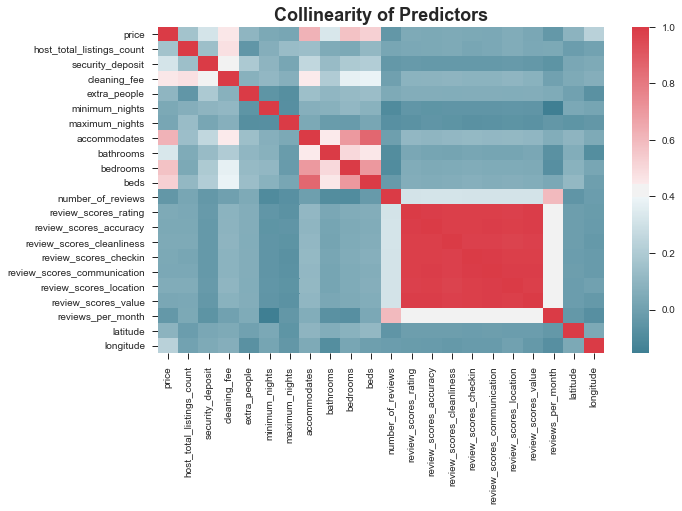

In [8]:
# Correlation matrix for all variables against each other
fig, ax = plt.subplots(figsize=(10,6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data[response+predictors].corr(), ax=ax, cmap=cmap)
ax.set_title('Collinearity of Predictors', fontweight='bold', fontsize=18)

plt.show()

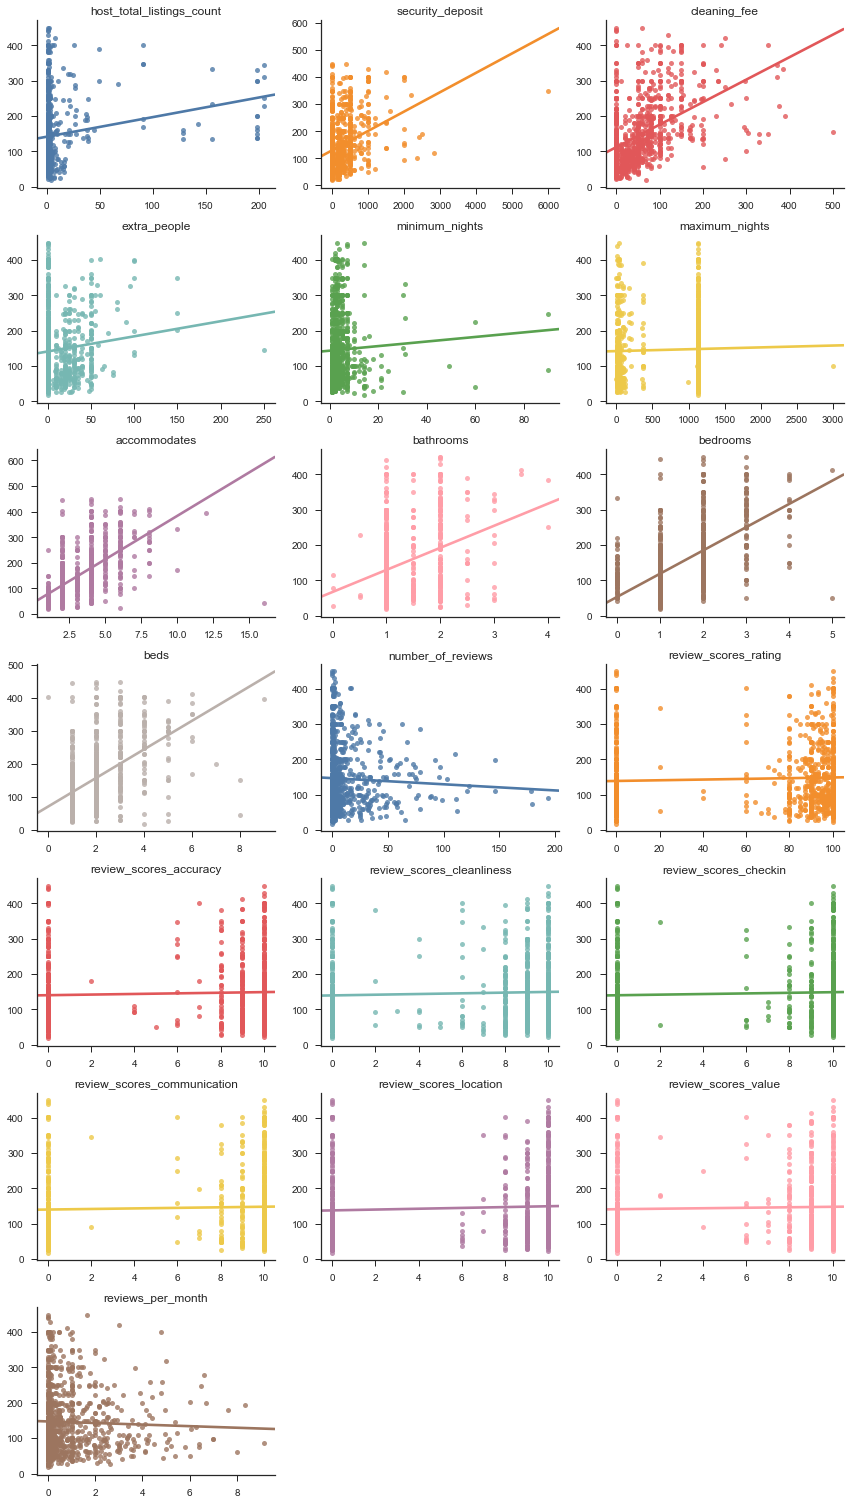

In [9]:
from statlearning import plot_regressions
with sns.color_palette(crayon):
    plot_regressions(data[continuous+discrete+reviews], data['price'])
    plt.show()

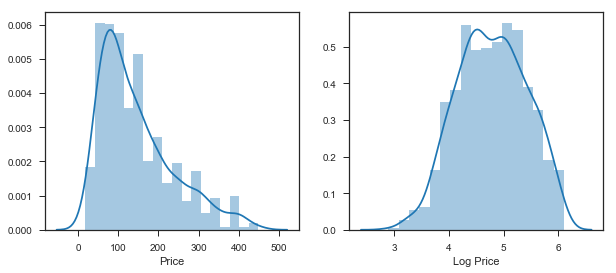

In [10]:
# Distribution of price

fig, ax = plt.subplots(1, 2, figsize=(10,4))

sns.distplot(data['price'], ax=ax[0])
ax[0].set_xlabel('Price')

sns.distplot(np.log(data['price']), ax=ax[1])
ax[1].set_xlabel('Log Price')

plt.show()

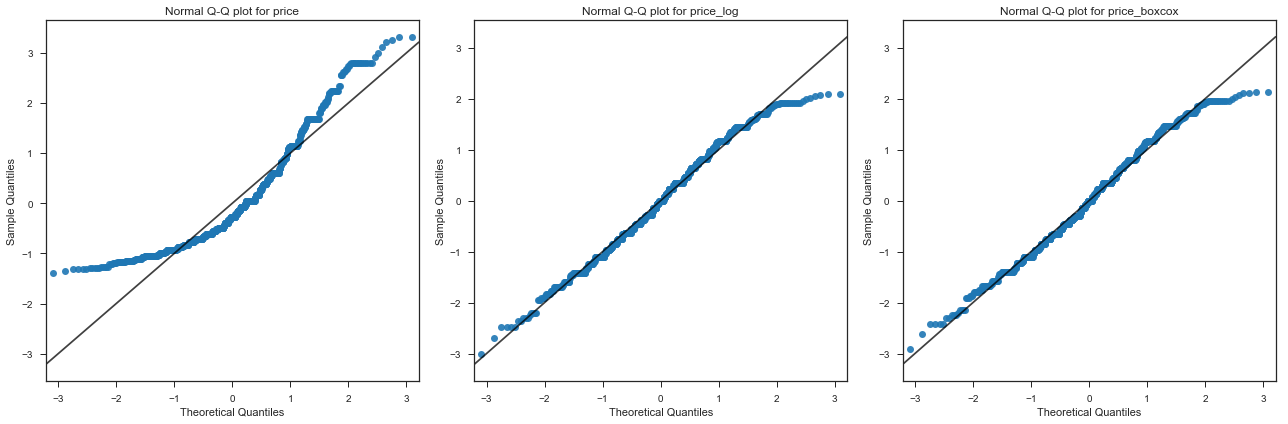

In [11]:
import scipy
from scipy import stats

# Normality of price
data['price_log'] = np.log(data['price'])
data['price_boxcox'] = scipy.stats.boxcox(data['price'])[0]

import statsmodels.api as sm
label = ['price', 'price_log', 'price_boxcox']

fig, ax = plt.subplots(1, 3, figsize = (18,6))
i = 0
for series in label:
    pp = sm.ProbPlot(data[series], fit=True)
    qq = pp.qqplot(color=sns.color_palette()[0], alpha=0.9, ax=ax[i])
    a = ax[i].get_xlim()[0]
    b = ax[i].get_xlim()[1]
    ax[i].plot([a,b], [a,b], color='black', alpha=0.75)
    ax[i].set_xlim(a, b)
    ax[i].set_title('Normal Q-Q plot for {}'.format(series))
    i += 1

plt.tight_layout()
plt.show()

In [12]:
data = data.drop(columns=['price_log', 'price_boxcox'])

In [13]:
from scipy import stats

# Non-parametric Kruskal-Wallis ANOVA rank test - discrete variables
H = []
p = []

for i in categorical+discrete:
    h, pval = stats.kruskal(*[data.loc[data[i]==v,'price'] for v in data[i].unique()])
    H.append(h)
    p.append(pval)

# Calculates significance at 1% and appends results
test_results = []
for value in p:
    if value < 0.01:
        test_results.append('True')
    else:
        test_results.append('False')

# Creates tables with the values above
table = pd.DataFrame(H, columns=['H Stat'], index=categorical+discrete)
table['p values'] = pd.DataFrame(p, index=categorical+discrete)
table['Reject, \u03b1=0.01'] = pd.DataFrame(test_results, index=categorical+discrete)

table.round(2)

,H Stat,p values,"Reject, α=0.01"
host_is_superhost,0.55,0.46,False
host_identity_verified,13.43,0.00,True
property_type,33.54,0.01,False
room_type,533.00,0.00,True
instant_bookable,2.97,0.08,False
is_business_travel_ready,10.81,0.00,True
cancellation_policy,76.36,0.00,True
accommodates,456.46,0.00,True
bathrooms,70.39,0.00,True
bedrooms,351.51,0.00,True


In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculating VIF for multicollinearity check
pred = continuous + discrete + reviews + coordinates

X = data[pred].as_matrix()
VIF = pd.DataFrame([np.sqrt(variance_inflation_factor(X,j)) for j in range(len(pred))], index=pred, columns=['SQRT(VIF)'])

VIF.sort_values(by='SQRT(VIF)', ascending=False).round(2)

,SQRT(VIF)
longitude,484.33
latitude,484.31
review_scores_rating,17.13
review_scores_communication,17.13
review_scores_checkin,16.30
review_scores_value,15.24
review_scores_accuracy,15.19
review_scores_location,12.73
review_scores_cleanliness,11.40
accommodates,4.25


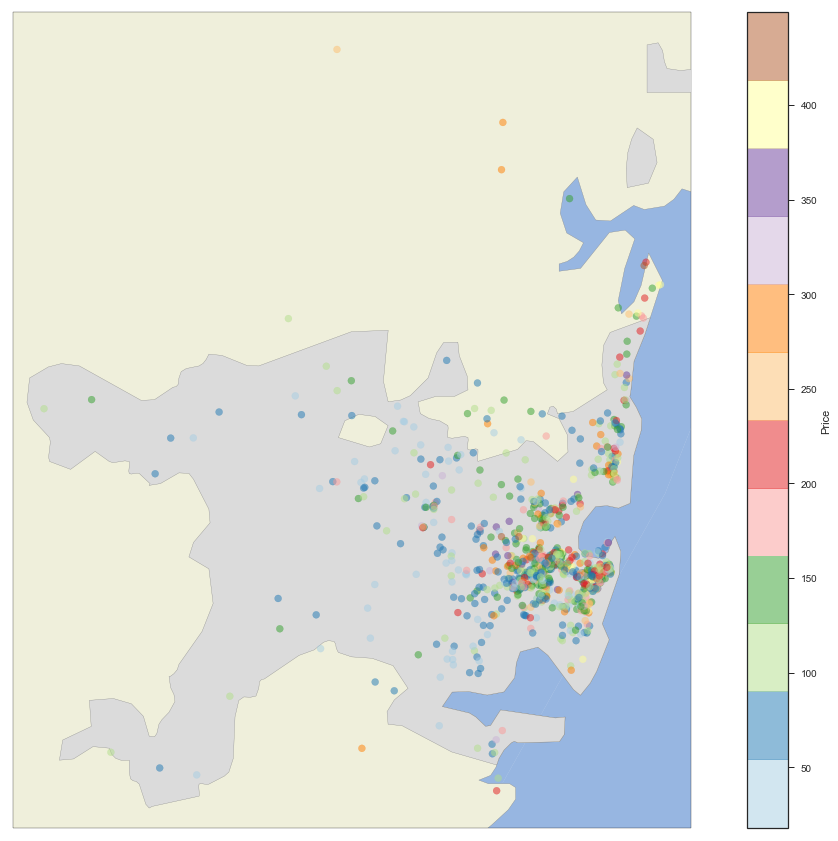

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize = (20,15)) # Plot

ax = plt.axes(projection=ccrs.Mercator()) # Map projection
ax.coastlines(resolution='10m') 

land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m',
                                    facecolor=cfeature.COLORS['land'])

pop = cfeature.NaturalEarthFeature(category='cultural', name='urban_areas', scale='10m', 
                                   facecolor=cfeature.COLORS['land_alt1'])

ax.add_feature(cfeature.LAND, facecolor=cfeature.COLORS['water'], zorder=1)
ax.add_feature(cfeature.OCEAN, zorder=1)

ax.add_feature(pop, edgecolor='gray', zorder=3)
ax.add_feature(land, edgecolor='gray', zorder=2)

plt.scatter(data['longitude'], data['latitude'], c=data['price'], alpha=0.5, transform=ccrs.Geodetic(), 
            cmap='Paired', zorder=8)

plt.colorbar().set_label('Price')
plt.show()

### Checking for interactions

In [16]:
# Orig data before imputation
data_temp = pd.read_csv('train.csv', index_col='Id')

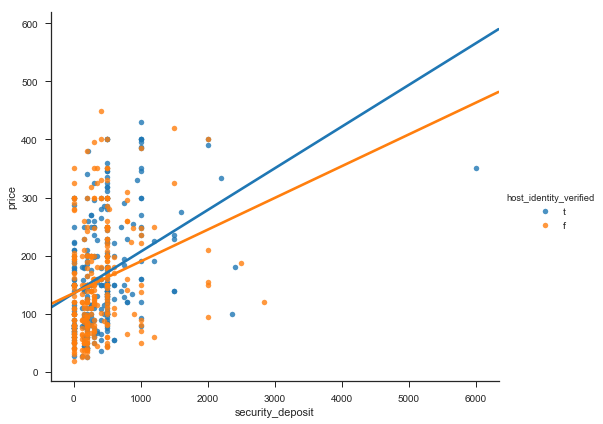

In [17]:
sns.lmplot('security_deposit', 'price', data=data_temp, hue='host_identity_verified', size=6, aspect=1.2, scatter_kws={'s': 30}, ci=None)
plt.show()

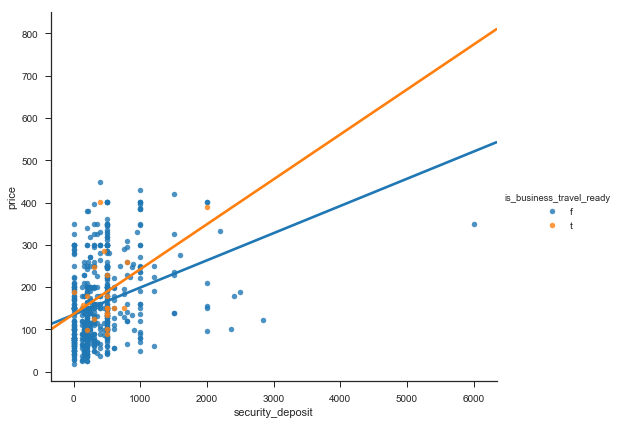

In [18]:
sns.lmplot('security_deposit', 'price', data=data_temp, hue='is_business_travel_ready', size=6, aspect=1.2, scatter_kws={'s': 30}, ci=None)
plt.show()

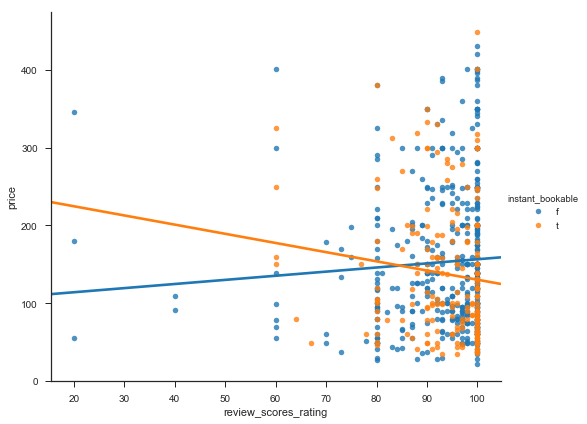

In [19]:
sns.lmplot('review_scores_rating', 'price', data=data_temp, hue='instant_bookable', size=6, aspect=1.2, scatter_kws={'s': 30}, ci=None)
plt.show()

In [20]:
col = 'instant_bookable'
pd.crosstab(data[col], data[col])

instant_bookable,f,t
instant_bookable,,
f,693,0
t,0,307


# Feature Engineering

In [21]:
# Dummies
dummies = pd.get_dummies(data[categorical], columns=categorical, drop_first=True)

data = data.drop(columns=data[categorical].columns)
data = pd.concat([data, dummies], axis=1)

In [22]:
# CREATE HAS REVIEW
# CREATE INTERACTIONS

In [23]:
# New variables

data['fee_per_person'] = (data['security_deposit'] + data['cleaning_fee']) / data['accommodates']

data['beds_per_person'] = data['beds'] / data['accommodates']

data['bathrooms_per_person'] = data['bathrooms'] / data['accommodates']

# These return errors due to dividing by 0 probably
#data['beds_per_bedroom'] = data['bedrooms'] / data['accomodates']
#data['bedrooms_per_person'] = data['bedrooms'] / data['accommodates']
#data['beds_per_bedrooms'] = data['beds'] / data['bedrooms']

In [24]:
# Combination of reviews
review_combination = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value']

data['average_review'] = data[review_combination].mean(axis=1)

data = data.drop(columns=data[review_combination].columns)

In [25]:
# Function to calculate distance between A and B with lat/lon
# https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
# Alternative could be clustering (kmeans) or something like s2-geometry-library or geohash

from math import radians, cos, sin, asin, sqrt
def great_circle_dist(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
   
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    
    # radius of earth in kilometers is 6371
    km = 6371 * c
    return km

In [26]:
%%time
syd_lat, syd_lon = -33.8587377, 151.210686

distance = []
for i in np.arange(len(data)):
    lat = data['latitude'].iloc[i]
    lon = data['longitude'].iloc[i]
    
    dist = great_circle_dist(syd_lat, syd_lon, lat, lon)
    distance.append(dist)

Wall time: 56 ms


In [27]:
data = data.drop(columns=data[coordinates].columns)
distance = pd.DataFrame(distance, columns=['distance'])
data = pd.concat([data, distance], axis=1)

In [28]:
# Final dataset
data.head()

,price,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month,host_is_superhost_t,host_identity_verified_t,property_type_Bed & Breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Condominium,property_type_Dorm,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_In-law,property_type_Loft,property_type_Other,property_type_Timeshare,property_type_Townhouse,property_type_Vacation home,property_type_Villa,room_type_Private room,room_type_Shared room,instant_bookable_t,is_business_travel_ready_t,cancellation_policy_moderate,cancellation_policy_strict,fee_per_person,beds_per_person,bathrooms_per_person,average_review,distance
0,150,22.0,2,1.0,1,1.0,500.0,330.0,0,7,1125,1.0,100.0,0.53,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,415.000000,0.500000,0.50,10.000000,1.456145
1,66,1.0,2,1.5,1,1.0,0.0,0.0,0,21,30,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.000000,0.500000,0.75,0.000000,5.356449
2,325,1.0,4,2.0,2,2.0,500.0,180.0,0,3,90,21.0,99.0,2.38,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,170.000000,0.500000,0.50,9.833333,2.531821
3,145,1.0,6,1.5,3,4.0,0.0,80.0,0,4,1125,3.0,100.0,1.96,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,13.333333,0.666667,0.25,10.000000,5.644431
4,200,6.0,4,1.0,2,2.0,350.0,85.0,50,2,30,22.0,97.0,2.73,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,108.750000,0.500000,0.25,10.000000,6.146362


# Models

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

In [35]:
response = 'price'
predictors = [x for x in list(data.columns) if x not in response]

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=42)

# Write training and test sets 
train = data.loc[index_train, :].copy()
test =  data.loc[index_test, :].copy()

# Write training and test response vectors
y_train = np.log(train[response])
y_test = np.log(test[response])

# Write training and test design matrices
X_train = train[predictors].copy()
X_test = test[predictors].copy()

### Linear Regression + KNN

In [94]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [95]:
%%time
model = KNeighborsRegressor() 
    
tuning_parameters = {
    'n_neighbors': np.arange(1, 51),
}

knn_search = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=1)

knn_search.fit(X_train, y_train)

knn = knn_search.best_estimator_
print('Best parameters:', knn_search.best_params_)

Best parameters: {'n_neighbors': 16}
Wall time: 1.68 s


### Lasso

In [96]:
lasso = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(cv=5)),
))

lasso.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])

### Ridge

In [97]:
alphas = list(np.logspace(-15, 15, 151, base=2))

ridge = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=5)),
))

ridge.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', RidgeCV(alphas=[3.0517578125e-05, 3.505549179068098e-05, 4.026818575356734e-05, 4.625599873383782e-05, 5.313418965430448e-05, 6.103515625e-05, 7.011098358136196e-05, 8.053637150713468e-05, 9.251199746767564e-0...cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False))])

### Elastic Net

In [98]:
enet = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)),
))

enet.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0))])

### Regression Tree

In [99]:
%%time

model = DecisionTreeRegressor(min_samples_leaf=5)

tuning_parameters = {
    'min_samples_leaf': [1, 5, 10, 20],
    'max_depth': np.arange(1, 30),
}

#tree = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=5, return_train_score=False, n_jobs=1, random_state=1)

tree = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=1)

tree.fit(X_train, y_train)

print('Best parameters:', tree.best_params_)

Best parameters: {'max_depth': 4, 'min_samples_leaf': 5}
Wall time: 2.5 s


### Bagging

In [100]:
%%time

bag = BaggingRegressor(n_estimators=500, random_state=1)
bag.fit(X_train, y_train)

Wall time: 2.34 s


### Random Forest

In [101]:
%%time

model = RandomForestRegressor(n_estimators=100)

tuning_parameters = {
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
}

#rf_search = RandomizedSearchCV(model, tuning_parameters, cv=5, n_iter=16, return_train_score=False, n_jobs=4, random_state=1)

rf_search = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=1)

rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

KeyboardInterrupt: 

In [102]:
rf.n_estimators = 500
rf.fit(X_train, y_train)

NameError: name 'rf' is not defined

### Boosting

In [ ]:
%%time
model = GradientBoostingRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2 ,3, 4],
    'subsample' : [0.6, 0.8, 1.0]
}

#gb = RandomizedSearchCV(model, tuning_parameters, n_iter=50, cv=10, return_train_score=False, n_jobs=1, random_state=1)

gb = GridSearchCV(model, tuning_parameters, cv=10, return_train_score=False, n_jobs=1)

gb.fit(X_train, y_train)

print('Best parameters found by grid search:', gb.best_params_, '\n')

In [ ]:
gb.best_estimator_

In [ ]:
from statlearning import plot_feature_importance

plot_feature_importance(gb.best_estimator_, predictors)
plt.show()

### XGBoost

In [ ]:
%%time

model = xgb.XGBRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter=16, cv=5, return_train_score=False, n_jobs=4, random_state=1)

gb_search.fit(X_train, y_train)

xbst = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

In [ ]:
plot_feature_importance(xbst, labels=predictors)
plt.show()

In [ ]:
%%time

dtrain = xgb.DMatrix(X_train, y_train) # we need to convert the data to the format required by xgboost
dtest  = xgb.DMatrix(X_test)

param = {
    'max_depth': 2, 
    'learning_rate': 0.1, 
    'subsample': 0.8,
    'silent' : 0, 
    'objective':'reg:linear',  
     }

cv = xgb.cv(param, dtrain, num_boost_round=1500, nfold=10, early_stopping_rounds=50)

print(f'Selected number of boosting iterations: {cv.shape[0]}')
print(f'RMSE (CV): {cv.iloc[-1,0]:.4f}')

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(cv.iloc[:,0])
ax.set_ylabel('Cross-validation RMSE')
ax.set_xlabel('Boosting iterations')
sns.despine()
plt.show()

### LightGBM

In [ ]:
%%time

model = lgb.LGBMRegressor(objective='regression')

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter=64, cv=5, return_train_score=False, n_jobs=4, random_state=1)

gb_search.fit(X_train, y_train)

lbst = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

### Adaptive Boosting

In [ ]:
%%time

y_fit = lasso.predict(X_train)
resid = y_train - y_fit

model = lgb.LGBMRegressor(objective='regression')


tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4, random_state=1)

gb_search.fit(X_train, resid)

abst = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

### Model Stacking

In [ ]:
%%time

#models = [ols, lasso, ridge, xbst]
models = [enet, rf, xbst, lbst]

stack = StackingCVRegressor(models, meta_regressor=LinearRegression(), cv=10)
stack.fit(X_train.values, y_train.ravel())

# Part 2
### Keras
https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

In [37]:
response = 'price'
predictors = [x for x in list(data.columns) if x not in response]

index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=42)

train = data.loc[index_train, :].copy()
test =  data.loc[index_test, :].copy()

y_train = train[response]
y_test = test[response]

X_train = train[predictors].copy()
X_test = test[predictors].copy()

In [33]:
from keras.models import Sequential
from keras.layers import Dense

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### MLP 1

In [20]:
# create model
model = Sequential()
model.add(Dense(len(X_train.columns), input_dim=len(X_train.columns),
                kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

# compile model / choose metric
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'acc'])

# fit model
model.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
700/700 [==============================] - 9s 13ms/step - loss: 16657.8284 - mean_squared_error: 16657.8284 - acc: 0.0014
Epoch 2/100
700/700 [==============================] - 10s 14ms/step - loss: 10165.1787 - mean_squared_error: 10165.1787 - acc: 0.0029
Epoch 3/100
700/700 [==============================] - 9s 13ms/step - loss: 8616.9727 - mean_squared_error: 8616.9727 - acc: 0.0043
Epoch 4/100
700/700 [==============================] - 9s 13ms/step - loss: 7797.1225 - mean_squared_error: 7797.1225 - acc: 0.0057
Epoch 5/100
700/700 [==============================] - 9s 13ms/step - loss: 7384.3546 - mean_squared_error: 7384.3546 - acc: 0.0043
Epoch 6/100
700/700 [==============================] - 9s 12ms/step - loss: 7190.2383 - mean_squared_error: 7190.2383 - acc: 0.0057
Epoch 7/100
700/700 [==============================] - 9s 13ms/step - loss: 7046.2538 - mean_squared_error: 7046.2538 - acc: 0.0014
Epoch 8/100
700/700 [==============================] - 9s 13ms/step - l

Epoch 60/100
700/700 [==============================] - 17s 24ms/step - loss: 3669.3748 - mean_squared_error: 3669.3748 - acc: 0.0129
Epoch 61/100
700/700 [==============================] - 17s 25ms/step - loss: 3615.1365 - mean_squared_error: 3615.1365 - acc: 0.0086
Epoch 62/100
700/700 [==============================] - 17s 24ms/step - loss: 3692.2594 - mean_squared_error: 3692.2594 - acc: 0.0071
Epoch 63/100
700/700 [==============================] - 17s 25ms/step - loss: 3710.8122 - mean_squared_error: 3710.8122 - acc: 0.0057
Epoch 64/100
700/700 [==============================] - 17s 24ms/step - loss: 3618.9419 - mean_squared_error: 3618.9419 - acc: 0.0057
Epoch 65/100
700/700 [==============================] - 14s 21ms/step - loss: 3610.8350 - mean_squared_error: 3610.8350 - acc: 0.0029
Epoch 66/100
700/700 [==============================] - 17s 24ms/step - loss: 3616.0922 - mean_squared_error: 3616.0922 - acc: 0.0043
Epoch 67/100
700/700 [==============================] - 16s 23

In [21]:
# Evaluate the model
# Without extra predictors
scores = model.evaluate(X_test, y_test, batch_size=10)
print('\n{0}: {1}'.format(model.metrics_names[1], scores[1]))

300/300 [==============================] - 1s 2ms/step

mean_squared_error: 5378.523225911458


### MLP 1 w/ Scaling

In [38]:
scaler = StandardScaler().fit(X_train)
standardised_X = scaler.transform(X_train)
standardised_X_test = scaler.transform(X_test)

In [26]:
model2 = Sequential()
model2.add(Dense(len(X_train.columns), input_dim=len(X_train.columns),
                kernel_initializer='normal', activation='relu'))
model2.add(Dense(1, kernel_initializer='normal'))

model2.compile(loss='mse', optimizer='adam', metrics=['mse', 'acc'])

model2.fit(standardised_X, y_train, epochs=100, batch_size=10)

Epoch 1/100
700/700 [==============================] - 12s 18ms/step - loss: 29184.4090 - mean_squared_error: 29184.4090 - acc: 0.0000e+00
Epoch 2/100
700/700 [==============================] - 12s 18ms/step - loss: 28473.3857 - mean_squared_error: 28473.3857 - acc: 0.0000e+00
Epoch 3/100
700/700 [==============================] - 15s 22ms/step - loss: 26734.3673 - mean_squared_error: 26734.3673 - acc: 0.0000e+00
Epoch 4/100
700/700 [==============================] - 13s 18ms/step - loss: 23866.8508 - mean_squared_error: 23866.8508 - acc: 0.0014
Epoch 5/100
700/700 [==============================] - 16s 23ms/step - loss: 20181.7334 - mean_squared_error: 20181.7334 - acc: 0.0014
Epoch 6/100
700/700 [==============================] - 15s 22ms/step - loss: 16265.5143 - mean_squared_error: 16265.5143 - acc: 0.0000e+00
Epoch 7/100
700/700 [==============================] - 15s 21ms/step - loss: 12634.8738 - mean_squared_error: 12634.8738 - acc: 0.0029
Epoch 8/100
700/700 [==================

700/700 [==============================] - 9s 12ms/step - loss: 2952.5768 - mean_squared_error: 2952.5768 - acc: 0.0129
Epoch 62/100
700/700 [==============================] - 9s 13ms/step - loss: 2943.0069 - mean_squared_error: 2943.0069 - acc: 0.0086
Epoch 63/100
700/700 [==============================] - 10s 15ms/step - loss: 2938.7363 - mean_squared_error: 2938.7363 - acc: 0.0114
Epoch 64/100
700/700 [==============================] - 10s 14ms/step - loss: 2926.5788 - mean_squared_error: 2926.5788 - acc: 0.0143
Epoch 65/100
700/700 [==============================] - 9s 12ms/step - loss: 2929.8782 - mean_squared_error: 2929.8782 - acc: 0.0086
Epoch 66/100
700/700 [==============================] - 9s 12ms/step - loss: 2924.5266 - mean_squared_error: 2924.5266 - acc: 0.0114
Epoch 67/100
700/700 [==============================] - 9s 12ms/step - loss: 2926.8804 - mean_squared_error: 2926.8804 - acc: 0.0057
Epoch 68/100
700/700 [==============================] - 9s 13ms/step - loss: 293

In [27]:
# Without extra predictors
scores = model2.evaluate(standardised_X_test, y_test, batch_size=10)
print('\n{0}: {1}'.format(model2.metrics_names[1], scores[1]))

300/300 [==============================] - 0s 903us/step

mean_squared_error: 4815.478198242187


### MLP 2 (w/ Scaling)

In [39]:
model3 = Sequential()
model3.add(Dense(len(X_train.columns), input_dim=len(X_train.columns),
                kernel_initializer='normal', activation='relu'))
model3.add(Dense(8, kernel_initializer='normal', activation='relu'))
model3.add(Dense(1, kernel_initializer='normal'))

model3.compile(loss='mse', optimizer='adam', metrics=['mse', 'acc'])
model3.fit(standardised_X, y_train, epochs=100, batch_size=10)

Epoch 1/100
700/700 [==============================] - 14s 20ms/step - loss: 29242.9837 - mean_squared_error: 29242.9837 - acc: 0.0000e+003s - loss: 28308.3378 - mean_squared_error
Epoch 2/100
700/700 [==============================] - 15s 21ms/step - loss: 28314.1273 - mean_squared_error: 28314.1273 - acc: 0.0000e+00
Epoch 3/100
700/700 [==============================] - 14s 21ms/step - loss: 23966.5907 - mean_squared_error: 23966.5907 - acc: 0.0000e+00
Epoch 4/100
700/700 [==============================] - 14s 21ms/step - loss: 15705.4126 - mean_squared_error: 15705.4126 - acc: 0.0014
Epoch 5/100
700/700 [==============================] - 14s 20ms/step - loss: 9011.3889 - mean_squared_error: 9011.3889 - acc: 0.0000e+00
Epoch 6/100
700/700 [==============================] - 14s 20ms/step - loss: 6573.9299 - mean_squared_error: 6573.9299 - acc: 0.0029
Epoch 7/100
700/700 [==============================] - 14s 21ms/step - loss: 5436.4350 - mean_squared_error: 5436.4350 - acc: 0.00573s -

In [41]:
scores = model3.evaluate(standardised_X_test, y_test, batch_size=10)
print('\n{0}: {1}'.format(model3.metrics_names[1], scores[1]))

300/300 [==============================] - 0s 2ms/step

mean_squared_error: 4564.931660970052


In [29]:
# Without extra predictors

300/300 [==============================] - 0s 1ms/step

mean_squared_error: 4710.8768595377605


In [44]:
standardised_X_pred = scaler.transform(data[predictors])

# Prediction
y_pred = model3.predict(standardised_X_pred, batch_size=10)
submission = pd.DataFrame(np.c_[data.index, y_pred], columns=['Id', 'price'])
submission.to_csv('kaggle_submission.csv',  index=False)

# Evaluation

In [43]:
# Original Prices
columns = ['Test RMSE', 'Test R2']
rows = ['OLS', 'Lasso', 'Ridge', 'Elastic Net', 'Tree', 'Bagged Trees', 'Random Forest', 'SKLearn Boost', 'XGBoost', 'LightGBM', 'Additive Boost', 'Stack']
results = pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [ols, lasso, ridge, enet, tree, bag, rf, gb, xbst, lbst, abst, stack]

for i, method in enumerate(methods):
    
    if method != stack:
        y_pred = np.exp(method.predict(X_test))   
        if method == abst:
            y_pred = np.exp(lasso.predict(X_test)+method.predict(X_test)) # combining predictions           
    else:
        y_pred = np.exp(method.predict(X_test.values))
        
    results.iloc[i,0] = np.sqrt(mean_squared_error(np.exp(y_test), y_pred))
    results.iloc[i,1] = r2_score(np.exp(y_test), y_pred)

results.round(3)

,Test RMSE,Test R2
OLS,65.352,0.469
Lasso,64.965,0.475
Ridge,66.276,0.454
Elastic Net,65.187,0.472
Tree,66.963,0.443
Bagged Trees,64.112,0.489
Random Forest,64.408,0.484
SKLearn Boost,64.073,0.490
XGBoost,64.370,0.485
LightGBM,65.199,0.472


In [44]:
# Log Prices
columns = ['Test RMSE', 'Test R2']
rows = ['OLS', 'Lasso', 'Ridge', 'Elastic Net', 'Tree', 'Bagged Trees', 'Random Forest', 'SKLearn Boost', 'XGBoost', 'LightGBM', 'Additive Boost', 'Stack']
results = pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [ols, lasso, ridge, enet, tree, bag, rf, gb, xbst, lbst, abst, stack]

for i, method in enumerate(methods):
    
    if method != stack:
        y_pred = method.predict(X_test)   
        if method == abst:
            y_pred = ols.predict(X_test) + method.predict(X_test)              
    else:
        y_pred = method.predict(X_test.values)
        
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i,1] = r2_score(y_test, y_pred)

results.round(3)

,Test RMSE,Test R2
OLS,0.389,0.609
Lasso,0.387,0.614
Ridge,0.393,0.601
Elastic Net,0.388,0.612
Tree,0.415,0.555
Bagged Trees,0.390,0.607
Random Forest,0.394,0.599
SKLearn Boost,0.387,0.614
XGBoost,0.388,0.612
LightGBM,0.422,0.541


# Prediction
Re-running all imputation and feature engineering on test set

In [42]:
test = pd.read_csv('test.csv')
data = test.copy()
data = data.drop(columns='Id')

data['host_is_superhost'].fillna(value='f', inplace=True)
data['host_identity_verified'].fillna(value='f', inplace=True)

# No costs
data['security_deposit'].fillna(value=0, inplace=True)
data['cleaning_fee'].fillna(value=0, inplace=True)

# Medians
data['bathrooms'].fillna(value=np.nanmedian(data['bedrooms']), inplace=True)
data['beds'].fillna(value=np.nanmedian(data['beds']), inplace=True)
data['host_total_listings_count'].fillna(value=np.nanmedian(data['host_total_listings_count']), inplace=True)

#Reviews
review_data = data.filter(regex='review')

no_reviews = review_data.loc[review_data['number_of_reviews'] == 0]
reviews = review_data.loc[review_data['number_of_reviews'] > 0]

no_reviews = no_reviews.fillna(value=0)
review_data = pd.concat([reviews, no_reviews], ignore_index=False).sort_index()

from sklearn.preprocessing import Imputer
impute = Imputer(strategy='median')
review_data_clean = impute.fit_transform(review_data)
review_data_clean = pd.DataFrame(review_data_clean, columns=review_data.columns)

# Combining cleaned data
data = data.drop(columns=review_data.columns)
data = pd.concat([data, review_data_clean], axis=1)

# Dummies
dummies = pd.get_dummies(data[categorical], columns=categorical, drop_first=True)
data = data.drop(columns=data[categorical].columns)
data = pd.concat([data, dummies], axis=1)

# Distance
syd_lat, syd_lon = -33.8587377, 151.210686

distance = []
for i in np.arange(len(data)):
    lat = data['latitude'].iloc[i]
    lon = data['longitude'].iloc[i]
    
    dist = great_circle_dist(syd_lat, syd_lon, lat, lon)
    distance.append(dist)
    
data = data.drop(columns=data[coordinates].columns)
distance = pd.DataFrame(distance, columns=['distance'])
data = pd.concat([data, distance], axis=1)

# New variables
data['fee_per_person'] = (data['security_deposit'] + data['cleaning_fee']) / data['accommodates']
data['beds_per_person'] = data['beds'] / data['accommodates']
data['bathrooms_per_person'] = data['bathrooms'] / data['accommodates']

# Combination of reviews
review_combination = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value']
data['average_review'] = data[review_combination].mean(axis=1)
data = data.drop(columns=data[review_combination].columns)

# To fill the missing bedroom values in test set
data['bedrooms'].fillna(value=np.nanmedian(data['bedrooms']), inplace=True)

# To add the Timeshare property that isn't in the test set
data['property_type_Timeshare'] = 0

data.head()

,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month,host_is_superhost_t,host_identity_verified_t,property_type_Bed & Breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Castle,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth House,property_type_Guest suite,property_type_Guesthouse,property_type_Heritage hotel (India),property_type_Hostel,property_type_House,property_type_In-law,property_type_Island,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Tent,property_type_Townhouse,property_type_Train,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Private room,room_type_Shared room,instant_bookable_t,is_business_travel_ready_t,cancellation_policy_moderate,cancellation_policy_strict,distance,fee_per_person,beds_per_person,bathrooms_per_person,average_review,property_type_Timeshare
0,1.0,3,1.0,1.0,1.0,131.0,60.0,20,5,1125,55.0,93.0,2.23,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.628710,63.666667,0.333333,0.333333,9.666667,0
1,1.0,4,1.0,2.0,2.0,200.0,100.0,0,2,1125,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5.730587,75.000000,0.500000,0.250000,0.000000,0
2,1.0,5,1.0,2.0,4.0,400.0,100.0,0,6,35,10.0,96.0,0.80,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,10.345569,100.000000,0.800000,0.200000,9.833333,0
3,1.0,2,1.0,1.0,1.0,0.0,30.0,20,2,1125,3.0,80.0,0.08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.141212,15.000000,0.500000,0.500000,8.000000,0
4,52.0,4,1.0,1.0,2.0,500.0,120.0,20,3,1125,5.0,80.0,0.09,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6.353274,155.000000,0.500000,0.250000,8.333333,0


In [70]:
# Using Stack method
y_pred = np.exp(stack.predict(data[predictors].values))
submission = pd.DataFrame(np.c_[data.index, y_pred], columns=['Id', 'price'])
submission.to_csv('kaggle_submission.csv',  index=False)

NameError: name 'stack' is not defined